# CEJST Dataset

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from us import states
from census import Census
import time
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import zipfile

from dotenv import load_dotenv
import requests
import json
import os
import datetime as dt
from tqdm import trange, tqdm
import UCSmpl

## Retrieve CEJST data

Unfortunatetly, this dataset must be stored locally in order to be unzipped, it also takes a few minutes to run ~3-5 minutes. This is because it is a very large dataset.

In [3]:
if not os.path.exists("..\\..\\cjest-data\\"):
    print('Downloading file from internet')
    r = requests.get(cjest_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("..\\..\\cjest-data\\")

    start = time.perf_counter()
    cjest_df = gpd.read_file("..\\..\\cjest-data\\usa.zip")
    end = time.perf_counter()
    print(f"It took {(end-start)/60:3f} minutes to load the CJEST data")
else:
    print("Loading from previously saved file...")
    start = time.perf_counter()
    cjest_df = gpd.read_file("..\\..\\cjest-data\\usa.zip")
    end = time.perf_counter()
    print(f"It took {(end-start)/60:3f} minutes to load the CJEST data")

Loading from previously saved file...
It took 4.161803 minutes to load the CJEST data


In [6]:
_TIGER_URL = "https://www2.census.gov/geo/tiger/"

def get_tiger_files(year, state_abbr, feature='tract'):
    """
    This function retrievs a TIGER shapefile from the United States Census
    website.

    Parameters
    ----------
    year : int
        The shapefile year of interest.
    state_abbr : str
        The abbreviation for the state of interest.
    feature : str, optional
        Indicates which TIGER file data feature to extract, by default 'tract'.
    """
    
    
    try:
        state = states.lookup(state_abbr)
        assert state, f"{state_abbr} is not a state in the U.S."
    except AssertionError as error:
        raise error

    _FEATURE_FILE = {'tract':f'TRACT/tl_{year}_{state.fips}_tract.zip',
                     'county':f"COUNTY/tl_{year}_us_county.zip"}
    data_route = f"TIGER{year}/{_FEATURE_FILE[feature]}"
    
    geo_df = gpd.read_file(_TIGER_URL+data_route)
    
    return geo_df

In [23]:
year = 2019
state_abbr = 'NH'
state = states.lookup(state_abbr)

In [8]:
%time state_df = get_tiger_files(year=year, state_abbr=state_abbr, feature='tract')

CPU times: total: 141 ms
Wall time: 1.2 s


In [13]:
us_contiguous = [state.name for state in states.STATES_CONTIGUOUS]
len(us_contiguous)

48

In [15]:
cejst_contiguous = cjest_df[cjest_df['SF'].isin(us_contiguous)]

<Axes: >

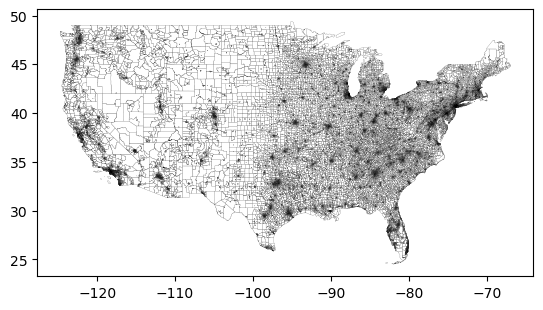

In [17]:
cejst_contiguous.to_crs(epsg=4269).plot(facecolor='w', edgecolor='k', lw=0.1)

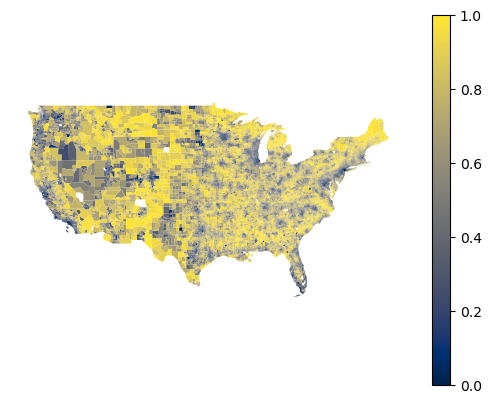

In [22]:
fig, ax = plt.subplots()
# cejst_contiguous.dissolve('CF').to_crs(epsg=4269).plot(ax=ax, column='EBF_PFS', cmap='',legend=True)
cejst_contiguous.to_crs(epsg=4269).plot(ax=ax, column='EBF_PFS', cmap='cividis',legend=True)
ax.set_axis_off()

In [24]:
state_cjest = cejst_contiguous[cejst_contiguous['SF'] == state.name].copy()

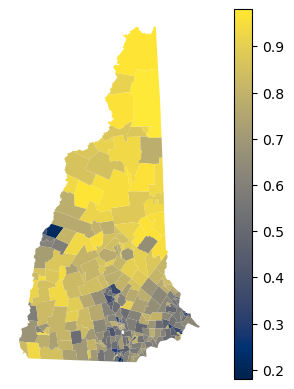

In [31]:
# county_lines = state_cjest.dissolve(by='CF')
state_cjest.to_crs(epsg=4269).plot(column='EBF_PFS', cmap='cividis',legend=True)
plt.gca().set_axis_off()